In [4]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
print(os.listdir("./cell_images"))

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['Uninfected', 'Parasitized']


In [5]:
parasitized_bright = os.listdir('./Parasitized_enlarge/bright/') 
parasitized_contrast = os.listdir('./Parasitized_enlarge/contrast/') 
parasitized_raw = os.listdir('./Parasitized_enlarge/raw/') 
uninfected_bright = os.listdir('./Uninfected_enlarge/bright/')
uninfected_contrast = os.listdir('./Uninfected_enlarge/contrast/') 
uninfected_raw = os.listdir('./Uninfected_enlarge/raw/') 
data = []
labels = []


In [6]:

for positive_data in parasitized_contrast:
    if positive_data == "Thumbs.db":
        continue
    image = Image.open("./Parasitized_enlarge/contrast/" + positive_data)
    image = image.resize((64, 64))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)

    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(1)
    labels.append(1)
    labels.append(1)
    labels.append(1)

for negative_data in uninfected_contrast:
    if negative_data == "Thumbs.db":
        continue
    image = Image.open("./Uninfected_enlarge/contrast/" + negative_data)
    image = image.resize((64, 64))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)
    
    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(0)
    labels.append(0)
    labels.append(0)
    labels.append(0)

In [7]:
Data = np.array(data)
Labels = np.array(labels)

np.save('Data' , Data)
np.save('Labels' , Labels)
print('Data : {} | labels : {}'.format(Data.shape , Labels.shape))

Data : (110232, 64, 64, 3) | labels : (110232,)


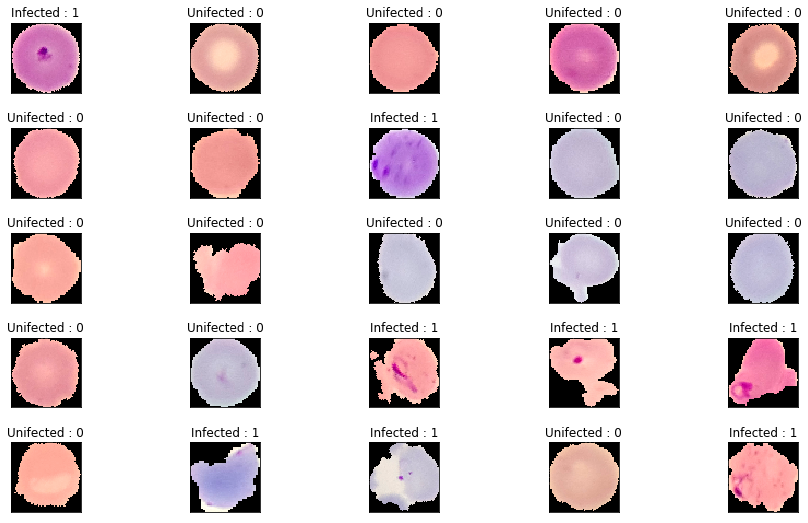

In [8]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(25):
    n += 1 
    r = np.random.randint(0 , Data.shape[0] , 1)
    plt.subplot(5 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(Data[r[0]])
    plt.title('{} : {}'.format('Infected' if Labels[r[0]] == 1 else 'Unifected' ,
                               Labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [9]:
from sklearn.utils import shuffle
Data, Labels = shuffle(Data, Labels)

In [10]:
Data = Data.astype(np.float32)
Data = Data / 255
Labels = Labels.astype(np.int32)

# Split Data

In [11]:
from sklearn.model_selection import train_test_split
ntrain = int(len(Data)*0.8)
X_test = Data[ntrain:]
y_test = Labels[ntrain:]
X_train, X_val, y_train, Y_val = train_test_split(Data[0:ntrain], Labels[0:ntrain], test_size=0.2, random_state = 40)

In [12]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 64, 64, 3])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
  
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    
    conv4 = tf.layers.conv2d(
        inputs=pool1,
        filters=256,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    # Dense Layer
    pool4 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2, padding = 'same')
    
    pool2_flat = tf.layers.flatten(pool4)

    dense1 = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units=128, activation=tf.nn.relu)
#     dropout = tf.layers.dropout(
#         inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dense2, units=2)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
          return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [13]:
# Create the Estimator
malaria_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/malaria_64*64_cnn")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/malaria_64*64_cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe23242def0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [15]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    batch_size=32,
    num_epochs=None,
    shuffle=True)

malaria_classifier.train(
    input_fn=train_input_fn,
    steps=50000)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/malaria_64*64_cnn/model.ckpt-135000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 135000 into /tmp/malaria_64*64_cnn/model.ckpt.
INFO:tensorflow:loss = 0.4843739, step = 135000
INFO:tensorflow:global_step/sec: 73.1374
INFO:tensorflow:loss = 0.094753705, step = 135100 (1.371 sec)
INFO:tensorflow:global_step/sec: 74.5112
INFO:tensorflow:loss = 0.1359537, step = 135200 (1.341 sec)
INFO:tensorflow:global_step/sec: 81.0214
INFO:tensorflow:loss = 0.2066487, step = 135300 (1.2

INFO:tensorflow:global_step/sec: 84.0913
INFO:tensorflow:loss = 0.06407724, step = 141700 (1.187 sec)
INFO:tensorflow:global_step/sec: 81.8419
INFO:tensorflow:loss = 0.024669744, step = 141800 (1.225 sec)
INFO:tensorflow:global_step/sec: 78.8491
INFO:tensorflow:loss = 0.08823507, step = 141900 (1.264 sec)
INFO:tensorflow:global_step/sec: 81.2433
INFO:tensorflow:loss = 0.10169247, step = 142000 (1.231 sec)
INFO:tensorflow:global_step/sec: 84.2528
INFO:tensorflow:loss = 0.04623249, step = 142100 (1.187 sec)
INFO:tensorflow:global_step/sec: 85.0738
INFO:tensorflow:loss = 0.042639438, step = 142200 (1.178 sec)
INFO:tensorflow:global_step/sec: 82.5937
INFO:tensorflow:loss = 0.044159982, step = 142300 (1.208 sec)
INFO:tensorflow:global_step/sec: 81.7937
INFO:tensorflow:loss = 0.18021233, step = 142400 (1.222 sec)
INFO:tensorflow:global_step/sec: 78.4187
INFO:tensorflow:loss = 0.018878195, step = 142500 (1.275 sec)
INFO:tensorflow:global_step/sec: 81.3788
INFO:tensorflow:loss = 0.0441094, ste

INFO:tensorflow:loss = 0.06445208, step = 149700 (1.200 sec)
INFO:tensorflow:global_step/sec: 82.9189
INFO:tensorflow:loss = 0.12243613, step = 149800 (1.205 sec)
INFO:tensorflow:global_step/sec: 83.8614
INFO:tensorflow:loss = 0.07786088, step = 149900 (1.192 sec)
INFO:tensorflow:global_step/sec: 81.3275
INFO:tensorflow:loss = 0.080286175, step = 150000 (1.231 sec)
INFO:tensorflow:global_step/sec: 83.068
INFO:tensorflow:loss = 0.12678683, step = 150100 (1.205 sec)
INFO:tensorflow:global_step/sec: 83.7285
INFO:tensorflow:loss = 0.072840154, step = 150200 (1.193 sec)
INFO:tensorflow:global_step/sec: 84.6232
INFO:tensorflow:loss = 0.14960945, step = 150300 (1.182 sec)
INFO:tensorflow:global_step/sec: 83.7747
INFO:tensorflow:loss = 0.03407506, step = 150400 (1.194 sec)
INFO:tensorflow:global_step/sec: 82.8822
INFO:tensorflow:loss = 0.14750084, step = 150500 (1.207 sec)
INFO:tensorflow:global_step/sec: 83.0619
INFO:tensorflow:loss = 0.29495597, step = 150600 (1.204 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 83.1853
INFO:tensorflow:loss = 0.2307761, step = 157800 (1.202 sec)
INFO:tensorflow:global_step/sec: 83.5986
INFO:tensorflow:loss = 0.10369357, step = 157900 (1.196 sec)
INFO:tensorflow:global_step/sec: 83.0655
INFO:tensorflow:loss = 0.023691796, step = 158000 (1.205 sec)
INFO:tensorflow:global_step/sec: 82.4678
INFO:tensorflow:loss = 0.0711082, step = 158100 (1.211 sec)
INFO:tensorflow:global_step/sec: 82.0709
INFO:tensorflow:loss = 0.06816475, step = 158200 (1.218 sec)
INFO:tensorflow:global_step/sec: 79.4962
INFO:tensorflow:loss = 0.043798763, step = 158300 (1.259 sec)
INFO:tensorflow:global_step/sec: 79.8244
INFO:tensorflow:loss = 0.016030237, step = 158400 (1.252 sec)
INFO:tensorflow:global_step/sec: 81.6724
INFO:tensorflow:loss = 0.063871585, step = 158500 (1.226 sec)
INFO:tensorflow:global_step/sec: 81.8703
INFO:tensorflow:loss = 0.048567943, step = 158600 (1.221 sec)
INFO:tensorflow:global_step/sec: 80.8696
INFO:tensorflow:loss = 0.031390406, st

INFO:tensorflow:loss = 0.015368847, step = 165800 (1.212 sec)
INFO:tensorflow:global_step/sec: 82.1281
INFO:tensorflow:loss = 0.098734826, step = 165900 (1.218 sec)
INFO:tensorflow:global_step/sec: 80.251
INFO:tensorflow:loss = 0.017216772, step = 166000 (1.245 sec)
INFO:tensorflow:global_step/sec: 82.1337
INFO:tensorflow:loss = 0.019481013, step = 166100 (1.218 sec)
INFO:tensorflow:global_step/sec: 82.4978
INFO:tensorflow:loss = 0.09945491, step = 166200 (1.214 sec)
INFO:tensorflow:global_step/sec: 82.7081
INFO:tensorflow:loss = 0.120711, step = 166300 (1.207 sec)
INFO:tensorflow:global_step/sec: 80.2077
INFO:tensorflow:loss = 0.13631116, step = 166400 (1.247 sec)
INFO:tensorflow:global_step/sec: 84.9061
INFO:tensorflow:loss = 0.039015308, step = 166500 (1.178 sec)
INFO:tensorflow:global_step/sec: 80.4265
INFO:tensorflow:loss = 0.05628848, step = 166600 (1.243 sec)
INFO:tensorflow:global_step/sec: 82.3583
INFO:tensorflow:loss = 0.14914188, step = 166700 (1.215 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 0.019349948, step = 173800 (1.182 sec)
INFO:tensorflow:global_step/sec: 82.6301
INFO:tensorflow:loss = 0.015179865, step = 173900 (1.211 sec)
INFO:tensorflow:global_step/sec: 84.0834
INFO:tensorflow:loss = 0.035002075, step = 174000 (1.190 sec)
INFO:tensorflow:global_step/sec: 84.6787
INFO:tensorflow:loss = 0.10779749, step = 174100 (1.182 sec)
INFO:tensorflow:global_step/sec: 85.8337
INFO:tensorflow:loss = 0.15372932, step = 174200 (1.164 sec)
INFO:tensorflow:global_step/sec: 87.0643
INFO:tensorflow:loss = 0.12779301, step = 174300 (1.148 sec)
INFO:tensorflow:global_step/sec: 84.7353
INFO:tensorflow:loss = 0.20765713, step = 174400 (1.181 sec)
INFO:tensorflow:global_step/sec: 83.9629
INFO:tensorflow:loss = 0.07845469, step = 174500 (1.190 sec)
INFO:tensorflow:global_step/sec: 85.9144
INFO:tensorflow:loss = 0.008659259, step = 174600 (1.164 sec)
INFO:tensorflow:global_step/sec: 87.7919
INFO:tensorflow:loss = 0.03213096, step = 174700 (1.140 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 0.22150505, step = 181800 (1.191 sec)
INFO:tensorflow:global_step/sec: 82.7594
INFO:tensorflow:loss = 0.037480995, step = 181900 (1.209 sec)
INFO:tensorflow:global_step/sec: 82.9872
INFO:tensorflow:loss = 0.0738045, step = 182000 (1.205 sec)
INFO:tensorflow:global_step/sec: 84.4035
INFO:tensorflow:loss = 0.10370467, step = 182100 (1.185 sec)
INFO:tensorflow:global_step/sec: 88.5878
INFO:tensorflow:loss = 0.025060404, step = 182200 (1.129 sec)
INFO:tensorflow:global_step/sec: 87.0176
INFO:tensorflow:loss = 0.017146036, step = 182300 (1.151 sec)
INFO:tensorflow:global_step/sec: 88.7122
INFO:tensorflow:loss = 0.025636854, step = 182400 (1.125 sec)
INFO:tensorflow:global_step/sec: 89.4567
INFO:tensorflow:loss = 0.07386866, step = 182500 (1.118 sec)
INFO:tensorflow:global_step/sec: 86.3753
INFO:tensorflow:loss = 0.16034497, step = 182600 (1.158 sec)
INFO:tensorflow:global_step/sec: 80.8133
INFO:tensorflow:loss = 0.009900856, step = 182700 (1.238 sec)
INFO:tensorflow:g

In [16]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_val},
    y=Y_val,
    num_epochs=1,
    shuffle=False)
eval_results = malaria_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-01-04:06:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/malaria_64*64_cnn/model.ckpt-185000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-01-04:06:55
INFO:tensorflow:Saving dict for global step 185000: accuracy = 0.9662074, global_step = 185000, loss = 0.10586819
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 185000: /tmp/malaria_64*64_cnn/model.ckpt-185000
{'accuracy': 0.9662074, 'loss': 0.10586819, 'global_step': 185000}
